running# Chapter 3


`Original content created by Cam Davidson-Pilon`

`Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)`
____


## Opening the black box of MCMC

The previous two chapters hid the inner-mechanics of PyMC3, and more generally Markov Chain Monte Carlo (MCMC), from the reader. The reason for including this chapter is three-fold. The first is that any book on Bayesian inference must discuss MCMC. I cannot fight this. Blame the statisticians. Secondly, knowing the process of MCMC gives you insight into whether your algorithm has converged. (Converged to what? We will get to that) Thirdly, we'll understand *why* we are returned thousands of samples from the posterior as a solution, which at first thought can be odd. 

### The Bayesian landscape

When we setup a Bayesian inference problem with $N$ unknowns, we are implicitly creating an $N$ dimensional space for the prior distributions to exist in. Associated with the space is an additional dimension, which we can describe as the *surface*, or *curve*, that sits on top of the space, that reflects the *prior probability* of a particular point. The surface on the space is defined by our prior distributions. For example, if we have two unknowns $p_1$ and $p_2$, and priors for both are $\text{Uniform}(0,5)$, the space created is a square of length 5 and the surface is a flat plane that sits on top of the square (representing that every point is equally likely). 

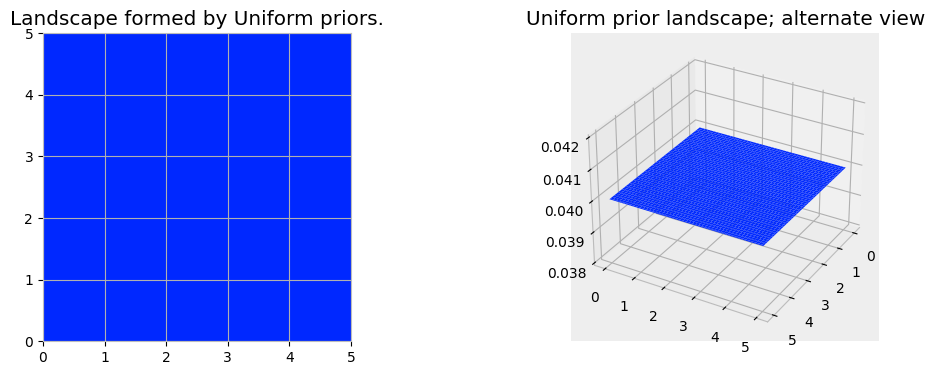

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; alternate view");

Alternatively, if the two priors are $\text{Exp}(3)$ and $\text{Exp}(10)$, then the space is all positive numbers on the 2-D plane, and the surface induced by the priors looks like a water fall that starts at the point (0,0) and flows over the positive numbers. 

The plots below visualize this. The more dark red the color, the more prior probability is assigned to that location. Conversely, areas with darker blue represent that our priors assign very low probability to that location. 

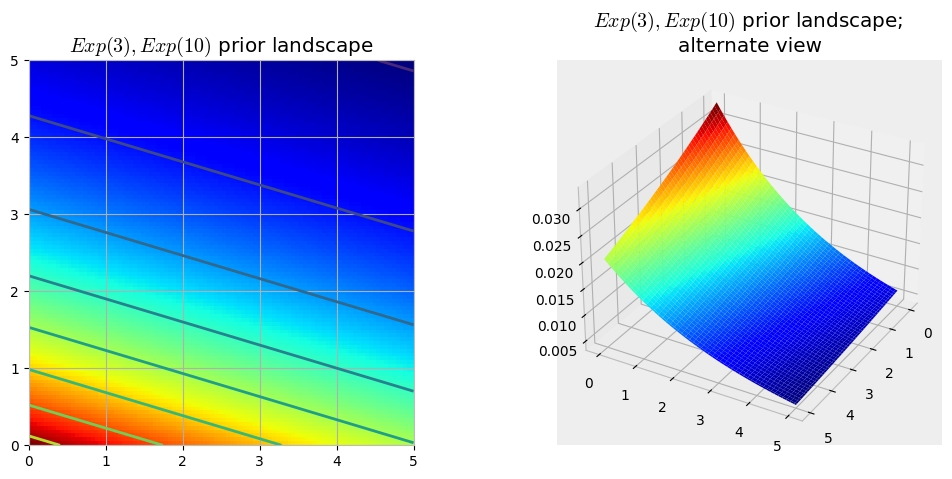

In [2]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(x, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
#plt.xlabel("prior on $p_1$")
#plt.ylabel("prior on $p_2$")
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \nalternate view");

These are simple examples in 2D space, where our brains can understand surfaces well. In practice, spaces and surfaces generated by our priors can be much higher dimensional. 

If these surfaces describe our *prior distributions* on the unknowns, what happens to our space after we incorporate our observed data $X$? The data $X$ does not change the space, but it changes the surface of the space by *pulling and stretching the fabric of the prior surface* to reflect where the true parameters likely live. More data means more pulling and stretching, and our original shape becomes mangled or insignificant compared to the newly formed shape. Less data, and our original shape is more present.  Regardless, the resulting surface describes the *posterior distribution*. 

Again I must stress that it is, unfortunately, impossible to visualize this in large dimensions. For two dimensions, the data essentially *pushes up* the original surface to make *tall mountains*. The tendency of the observed data to *push up* the posterior probability in certain areas is checked by the prior probability distribution, so that less prior probability means more resistance. Thus in the double-exponential prior case above, a mountain (or multiple mountains) that might erupt near the (0,0) corner would be much higher than mountains that erupt closer to (5,5), since there is more resistance (low prior probability) near (5,5). The peak reflects the posterior probability of where the true parameters are likely to be found. Importantly, if the prior has assigned a probability of 0, then no posterior probability will be assigned there. 

Suppose the priors mentioned above represent different parameters $\lambda$ of two Poisson distributions. We observe a few data points and visualize the new landscape: 

In [3]:
# create the observed data

# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 1

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print(f"observed (2-dimensional, sample size = {N}):", data)

# plotting details.
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

observed (2-dimensional,sample size = 1): [[2 0]]


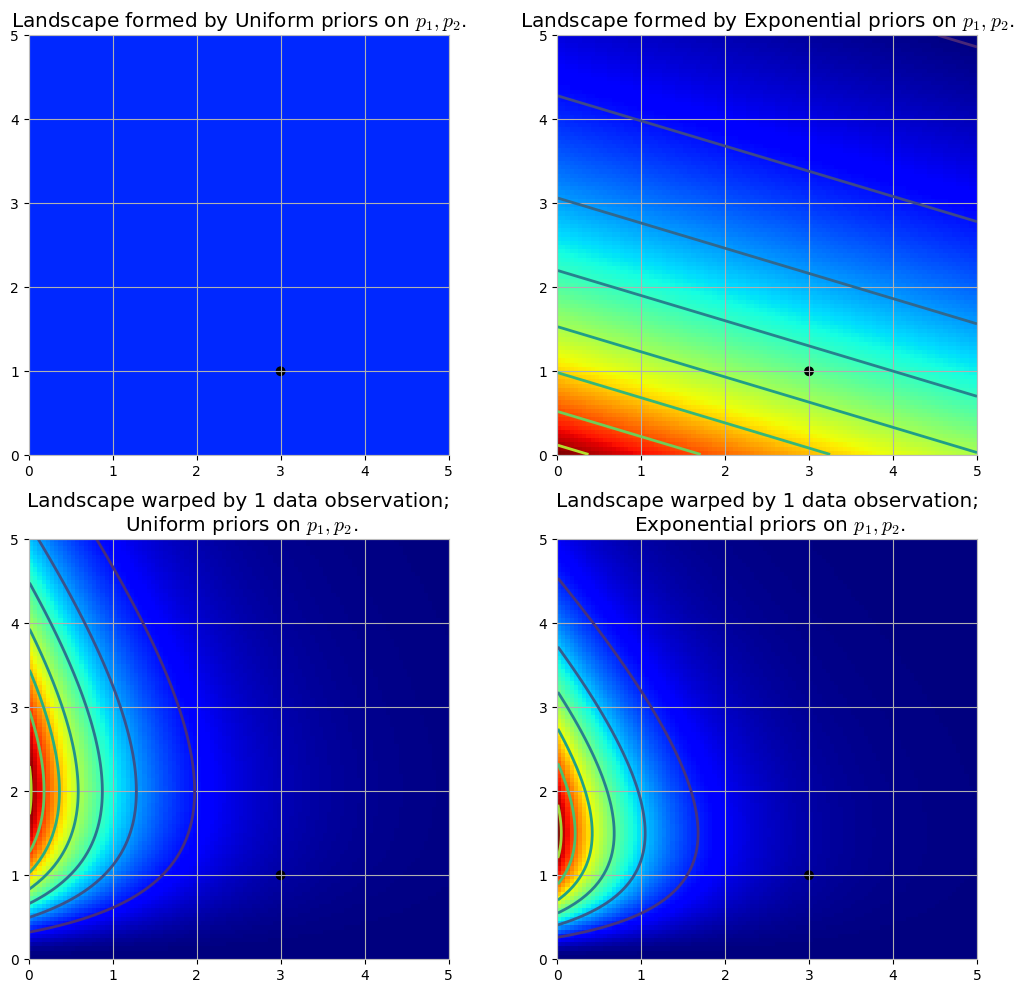

In [4]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);

The plot on the left is the deformed landscape with the $\text{Uniform}(0,5)$ priors, and the plot on the right is the deformed landscape with the exponential priors. Notice that the posterior landscapes look different from one another, though the data observed is identical in both cases. The reason is as follows. Notice the exponential-prior landscape, bottom right figure, puts very little *posterior* weight on values in the upper right corner of the figure: this is because *the prior does not put much weight there*. On the other hand, the uniform-prior landscape is happy to put posterior weight in the upper-right corner, as the prior puts more weight there. 

Notice also the highest-point, corresponding the the darkest red, is biased towards (0,0) in the exponential case, which is the result from the exponential prior putting more prior weight in the (0,0) corner.

The black dot represents the true parameters. Even with 1 sample point, the mountains attempts to contain the true parameter. Of course, inference with a sample size of 1 is incredibly naive, and choosing such a small sample size was only illustrative. 

It's a great exercise to try changing the sample size to other values (try 2,5,10,100?...) and observing how our "mountain" posterior changes. 

### Exploring the landscape using the MCMC

We should explore the deformed posterior space generated by our prior surface and observed data to find the posterior mountain. However, we cannot naively search the space: any computer scientist will tell you that traversing $N$-dimensional space is exponentially difficult in $N$: the size of the space quickly blows-up as we increase $N$ (see [the curse of dimensionality](http://en.wikipedia.org/wiki/Curse_of_dimensionality)). What hope do we have to find these hidden mountains? The idea behind MCMC is to perform an intelligent search of the space. To say "search" implies we are looking for a particular point, which is perhaps not an accurate as we are really looking for a broad mountain. 

Recall that MCMC returns *samples* from the posterior distribution, not the distribution itself. Stretching our mountainous analogy to its limit, MCMC performs a task similar to repeatedly asking  "How likely is this pebble I found to be from the mountain I am searching for?", and completes its task by returning thousands of accepted pebbles in hopes of reconstructing the original mountain. In MCMC and PyMC3 lingo, the returned sequence of "pebbles" are the samples,  cumulatively called the *traces*. 

When I say MCMC intelligently searches, I really am saying MCMC will *hopefully* converge towards the areas of high posterior probability. MCMC does this by exploring nearby positions and moving into areas with higher probability. Again, perhaps "converge" is not an accurate term to describe MCMC's progression. Converging usually implies moving towards a point in space, but MCMC moves towards a *broader area* in the space and randomly walks in that area, picking up samples from that area.

#### Why Thousands of Samples?

At first, returning thousands of samples to the user might sound like being an inefficient way to describe the posterior distributions. I would argue that this is extremely efficient. Consider the alternative possibilities:

1. Returning a mathematical formula for the "mountain ranges" would involve describing a N-dimensional surface with arbitrary peaks and valleys.
2. Returning the "peak" of the landscape, while mathematically possible and a sensible thing to do as the highest point corresponds to most probable estimate of the unknowns, ignores the shape of the landscape, which we have previously argued is very important in determining posterior confidence in unknowns. 

Besides computational reasons, likely the strongest reason for returning samples is that we can easily use *The Law of Large Numbers* to solve otherwise intractable problems. I postpone this discussion for the next chapter. With the thousands of samples, we can reconstruct the posterior surface by organizing them in a histogram. 


### Algorithms to perform MCMC

There is a large family of algorithms that perform MCMC. Most of these algorithms can be expressed at a high level as follows: (Mathematical details can be found in the appendix.)

1. Start at current position.
2. Propose moving to a new position (investigate a pebble near you).
3. Accept/Reject the new position based on the position's adherence to the data and prior distributions (ask if the pebble likely came from the mountain).
4.  1.  If you accept: Move to the new position. Return to Step 1.
    2. Else: Do not move to new position. Return to Step 1. 
5. After a large number of iterations, return all accepted positions.

This way we move in the general direction towards the regions where the posterior distributions exist, and collect samples sparingly on the journey. Once we reach the posterior distribution, we can easily collect samples as they likely all belong to the posterior distribution. 

If the current position of the MCMC algorithm is in an area of extremely low probability, which is often the case when the algorithm begins (typically at a random location in the space), the algorithm will move in positions *that are likely not from the posterior* but better than everything else nearby. Thus the first moves of the algorithm are not reflective of the posterior.

In the above algorithm's pseudocode, notice that only the current position matters (new positions are investigated only near the current position). We can describe this property as *memorylessness*, i.e. the algorithm does not care *how* it arrived at its current position, only that it is there. 

### Other approximation solutions to the posterior
Besides MCMC, there are other procedures available for determining the posterior distributions. A Laplace approximation is an approximation of the posterior using simple functions. A more advanced method is [Variational Bayes](http://en.wikipedia.org/wiki/Variational_Bayesian_methods). All three methods, Laplace Approximations, Variational Bayes, and classical MCMC have their pros and cons. We will only focus on MCMC in this book. That being said, my friend Imri Sofar likes to classify MCMC algorithms as either "they suck", or "they really suck". He classifies the particular flavour of MCMC used by PyMC3 as just *sucks* ;)

##### Example: Unsupervised Clustering using a Mixture Model


Suppose we are given the following dataset:


[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


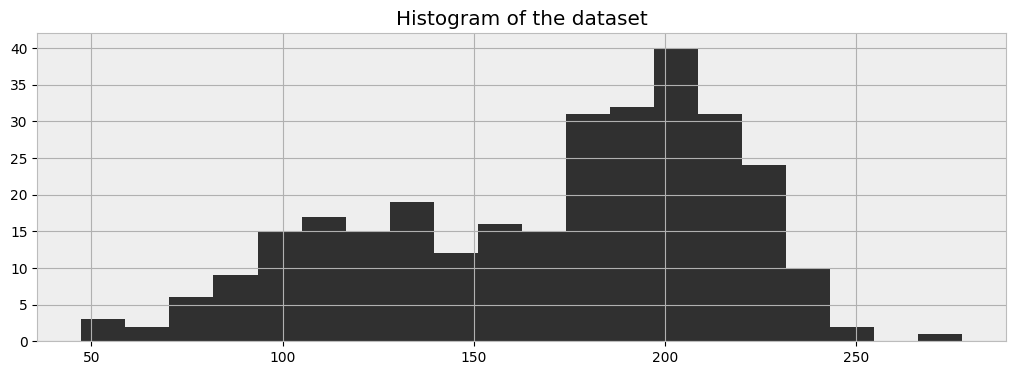

In [5]:
figsize(12.5, 4)
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")

What does the data suggest? It appears the data has a bimodal form, that is, it appears to have two peaks, one near 120 and the other near 200. Perhaps there are *two clusters* within this dataset. 

This dataset is a good example of the data-generation modeling technique from last chapter. We can propose *how* the data might have been created. I suggest the following data generation algorithm: 

1. For each data point, choose cluster 1 with probability $p$, else choose cluster 2. 
2. Draw a random variate from a Normal distribution with parameters $\mu_i$ and $\sigma_i$ where $i$ was chosen in step 1.
3. Repeat.

This algorithm would create a similar effect as the observed dataset, so we choose this as our model. Of course, we do not know $p$ or the parameters of the Normal distributions. Hence we must infer, or *learn*, these unknowns.

Denote the Normal distributions $\text{N}_0$ and $\text{N}_1$ (having variables' index start at 0 is just Pythonic). Both currently have unknown mean and standard deviation, denoted $\mu_i$ and $\sigma_i, \; i =0,1$ respectively. A specific data point can be from either $\text{N}_0$ or $\text{N}_1$, and we assume that the data point is assigned to $\text{N}_0$ with probability $p$.


An appropriate way to assign data points to clusters is to use a PyMC3 `Categorical` stochastic variable. Its parameter is a $k$-length array of probabilities that must sum to one and its `value` attribute is a integer between 0 and $k-1$ randomly chosen according to the crafted array of probabilities (In our case $k=2$). *A priori*, we do not know what the probability of assignment to cluster 1 is, so we form a uniform variable on $(0, 1)$. We call call this $p_1$, so the probability of belonging to cluster 2 is therefore $p_2 = 1 - p_1$.

Unfortunately, we can't we just give `[p1, p2]` to our `Categorical` variable. PyMC3 uses Theano under the hood to construct the models so we need to use `theano.tensor.stack()` to combine $p_1$ and $p_2$ into a vector that it can understand. We pass this vector into the `Categorical` variable as well as the `testval` parameter to give our variable an idea of where to start from.

In [6]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax.random import PRNGKey
from numpyro import deterministic, plate, sample

# Utility functions
def seed(rng_seed=1):
    return numpyro.handlers.seed(rng_seed=rng_seed)

def batch(size=8, **kwargs):
    return plate("batch", size, **kwargs)

In [7]:
n_observations = data.shape[0]

def assignment_model():
    p = sample("p", dist.Dirichlet(jnp.ones(2)))
    with plate("data", n_observations):
        return sample("assignment", dist.Categorical(p)) 

with seed():
    print("Assignment from prior predictive:")
    print(assignment_model()[:10], "...")

Assignment from prior predictive:
[1 0 0 1 1 1 0 1 0 0] ...


Looking at the above dataset, I would guess that the standard deviations of the two Normals are different. To maintain ignorance of what the standard deviations might be, we will initially model them as uniform on 0 to 100. We will include both standard deviations in our model using a single line of PyMC3 code:

    sds = pm.Uniform("sds", 0, 100, shape=2)

Notice that we specified `shape=2`: we are modeling both $\sigma$s as a single PyMC3 variable. Note that this does not induce a necessary relationship between the two $\sigma$s, it is simply for succinctness.

We also need to specify priors on the centers of the clusters. The centers are really the $\mu$ parameters in these Normal distributions. Their priors can be modeled by a Normal distribution. Looking at the data, I have an idea where the two centers might be &mdash; I would guess somewhere around 120 and 190 respectively, though I am not very confident in these eyeballed estimates. Hence I will set $\mu_0 = 120, \mu_1 = 190$ and $\sigma_0 = \sigma_1 = 10$.

In [8]:
def model(data=None):
    p = sample("p", dist.Uniform(0, 1))
    mu_c = jnp.array([120, 190])

    with plate("components", 2):
        centers = sample("centers", dist.Normal(mu_c, 10))
        sds = sample("sds", dist.Uniform(0, 100))

    # and to combin§e it with the observations:
    with plate("data", n_observations):
        assignment = sample("assignment", dist.Bernoulli(p)) 
        center_i = deterministic("center_i", centers[assignment])
        sd_i = deterministic("sd_i", sds[assignment])
        return sample("obs", dist.Normal(center_i, sd_i), obs=data)

with seed():
    model_trace = numpyro.handlers.trace(model).get_trace()
    print("Random assignments: ", model_trace["assignment"]["value"][:4], "...")
    print("Assigned center: ", model_trace["center_i"]["value"][:4], "...")

Random assignments:  [0 0 1 0] ...
Assigned center:  [125.75223 125.75223 190.04251 125.75223] ...


Random assignments:  [0 0 1 0] ...
Assigned center:  [125.75223 125.75223 190.04251 125.75223] ...
Assigned standard deviation:  [34.444965 34.444965 58.27681  34.444965]


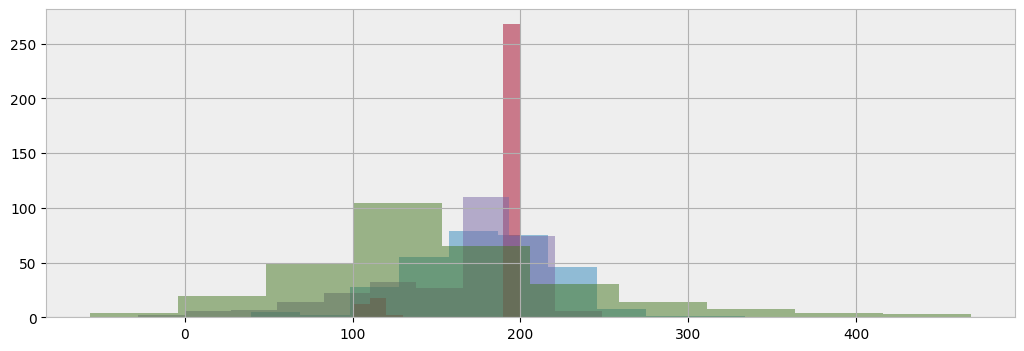

In [9]:
from numpyro.handlers import trace

figsize(12.5, 4)
with seed():
    model_trace = numpyro.handlers.trace(model).get_trace()
    print("Random assignments: ", model_trace["assignment"]["value"][:4], "...")
    print("Assigned center: ", model_trace["center_i"]["value"][:4], "...")
    print("Assigned standard deviation: ", model_trace["sd_i"]["value"][:4])
    for _ in range(4):
        plt.hist(model(), alpha=0.5)

Notice how we continue to build the model within the context of `Model()`. This automatically adds the variables that we create to our model. As long as we work within this context we will be working with the same variables that we have already defined.

Similarly, any sampling that we do within the context of `Model()` will be done only on the model whose context in which we are working. We will tell our model to explore the space that we have so far defined by defining the sampling methods, in this case `Metropolis()` for our continuous variables and `ElemwiseCategorical()` for our categorical variable. We will use these sampling methods together to explore the space by using `sample( iterations, step )`, where `iterations` is the number of steps you wish the algorithm to perform and `step` is the way in which you want to handle those steps. We use our combination of `Metropolis()` and `ElemwiseCategorical()` for the `step` and sample 25000 `iterations` below.


In [10]:
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS

kernel = DiscreteHMCGibbs(NUTS(model))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=8000)
mcmc.run(PRNGKey(1), data=data)
posterior_samples = mcmc.get_samples()

sample: 100%|███████████████████| 9000/9000 [01:08<00:00, 131.77it/s, 7 steps of size 4.81e-01. acc. prob=0.89]


We have stored the paths of all our variables, or "traces", in the `trace` variable. These paths are the routes the unknown parameters (centers, precisions, and $p$) have taken thus far. The individual path of each variable is indexed by the PyMC3 variable `name` that we gave that variable when defining it within our model. For example, `trace["sds"]` will return a `numpy array` object that we can then index and slice as we would any other `numpy array` object. 


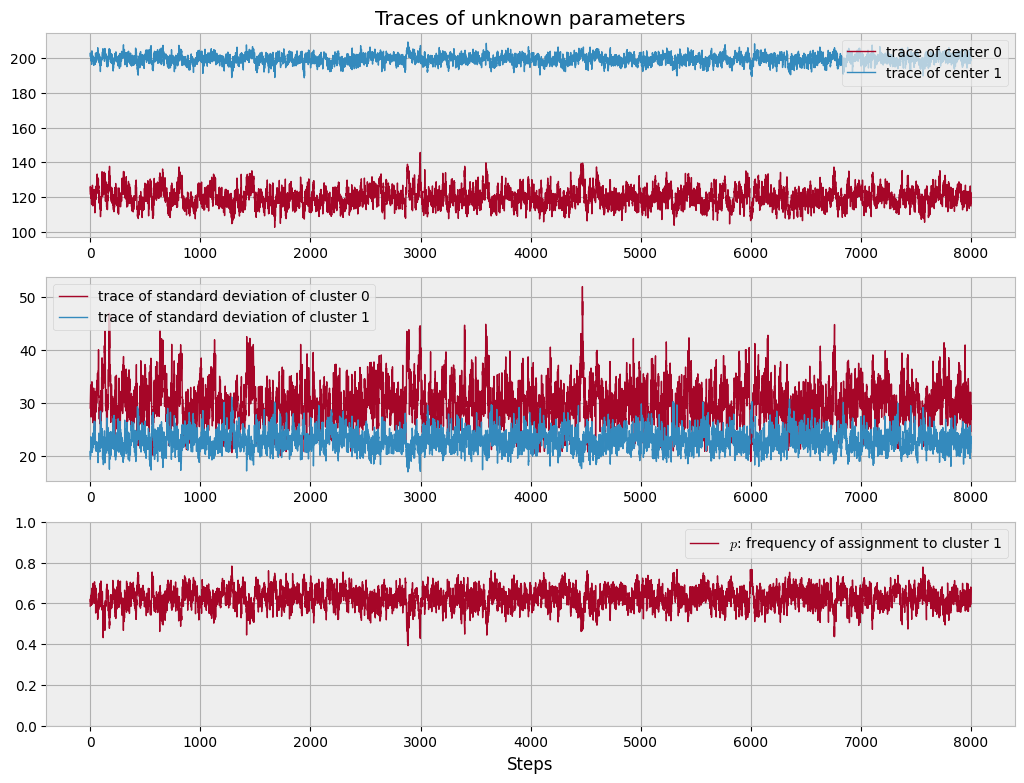

In [11]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_samples = posterior_samples["centers"]

# for pretty colors later in the book.
colors = (
    ["#348ABD", "#A60628"]
    if center_samples[-1, 0] > center_samples[-1, 1]
    else ["#A60628", "#348ABD"]
)

plt.plot(center_samples[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_samples[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_samples = posterior_samples["sds"]
plt.plot(std_samples[:, 0],
         label="trace of standard deviation of cluster 0",
         c=colors[0], lw=lw)
plt.plot(std_samples[:, 1],
         label="trace of standard deviation of cluster 1",
         c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
plt.plot(
    posterior_samples["p"],
    label="$p$: frequency of assignment to cluster 1",
    color=colors[0],
    lw=lw,
)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

Notice the following characteristics:

1. The traces converges, not to a single point, but to a *distribution* of possible points. This is *convergence* in an MCMC algorithm.
2. Inference using the first few thousand points is a bad idea, as they are unrelated to the final distribution we are interested in. Thus is it a good idea to discard those samples before using the samples for inference. We call this period before converge the *burn-in period*.
3. The traces appear as a random "walk" around the space, that is, the paths exhibit correlation with previous positions. This is both good and bad. We will always have correlation between current positions and the previous positions, but too much of it means we are not exploring the space well. This will be detailed in the Diagnostics section  later in this chapter.


To achieve further convergence, we will perform more MCMC steps. In the pseudo-code algorithm of MCMC above, the only position that matters is the current position (new positions are investigated near the current position), implicitly stored as part of the `trace` object. To continue where we left off, we pass the `trace` that we have already stored into the `sample()` function with the same step value. The values that we have already calculated will not be overwritten. This ensures that our sampling continues where it left off in the same way that it left off. 

We will sample the MCMC fifty thousand more times and visualize the progress below:

In [12]:
mcmc.post_warmup_state = mcmc.last_state
mcmc.run(mcmc.last_state.rng_key, data=data)
more_posterior_samples = mcmc.get_samples()

sample: 100%|███████████████████| 8000/8000 [00:53<00:00, 150.26it/s, 7 steps of size 4.81e-01. acc. prob=0.89]


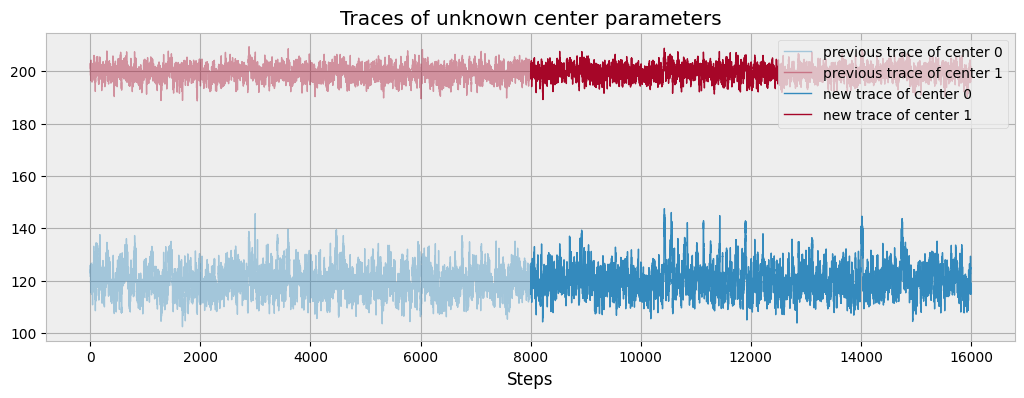

In [13]:
figsize(12.5, 4)
centers_1 = posterior_samples["centers"]
centers_2 = more_posterior_samples["centers"]

x = np.arange(len(centers_1))
plt.plot(x, centers_1[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.4, c=colors[1])
plt.plot(x, centers_1[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.4, c=colors[0])

x = np.arange(len(centers_1), len(centers_1) + len(centers_2))
plt.plot(x, centers_2[:, 0], label="new trace of center 0", lw=lw, c="#348ABD")
plt.plot(x, centers_2[:, 1], label="new trace of center 1", lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");




#### Cluster Investigation

We have not forgotten our main challenge: identify the clusters. We have determined posterior distributions for our unknowns. We plot the posterior distributions of the center and standard deviation variables below:

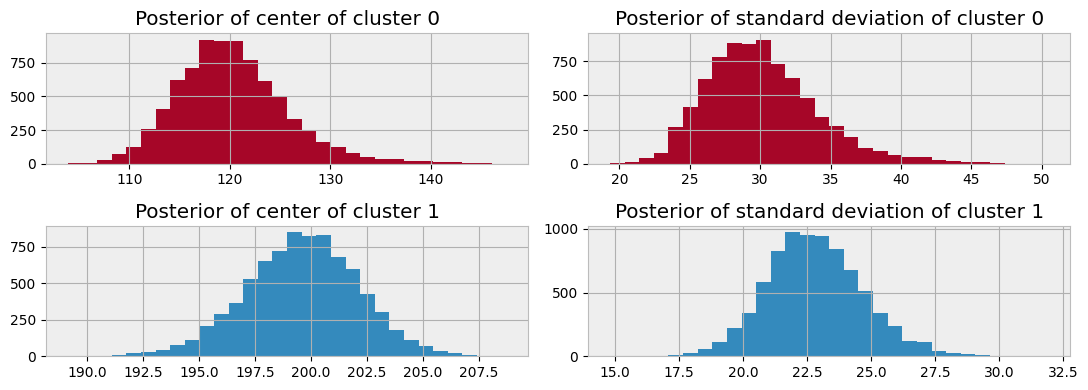

In [14]:
figsize(11.0, 4)

ax_i = iter(range(1, 5))
for i in range(2):
    plt.subplot(2, 2, next(ax_i))
    plt.title(f"Posterior of center of cluster {i}")
    plt.hist(more_posterior_samples["centers"][:, i],
             color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, next(ax_i))
    plt.title(f"Posterior of standard deviation of cluster {i}")
    plt.hist(more_posterior_samples["sds"][:, i],
             color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

The MCMC algorithm has proposed that the most likely centers of the two clusters are near 120 and 200 respectively. Similar inference can be applied to the standard deviation. 

We are also given the posterior distributions for the labels of the data point, which is present in `trace["assignment"]`. Below is a visualization of this. The y-axis represents a subsample of the posterior labels for each data point. The x-axis are the sorted values of the data points. A red square is an assignment to cluster 1, and a blue square is an assignment to cluster 0. 

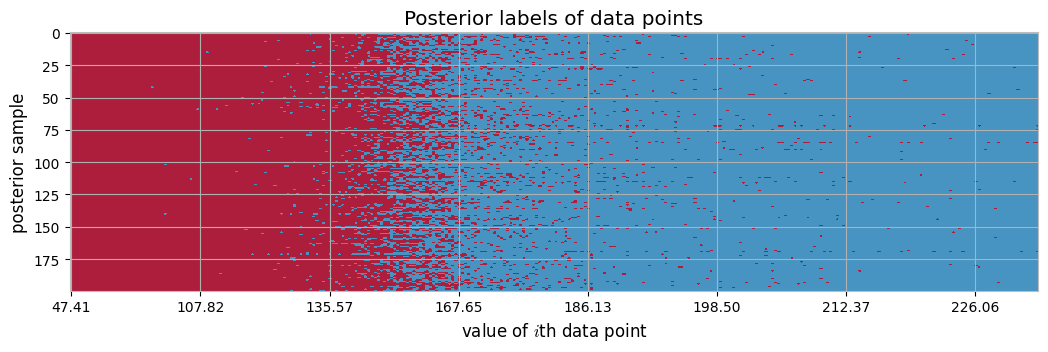

In [15]:
import matplotlib as mpl
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(posterior_samples["assignment"][::40, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

Looking at the above plot, it appears that the most uncertainty is between 150 and 170. The above plot slightly misrepresents things, as the x-axis is not a true scale (it displays the value of the $i$th sorted data point.) A more clear diagram is below, where we have estimated the *frequency* of each data point belonging to the labels 0 and 1. 

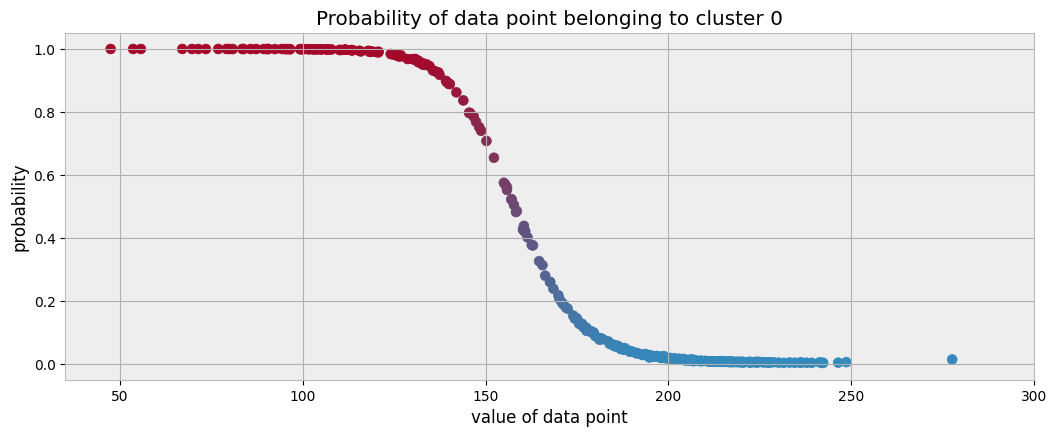

In [16]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assignment_mean = posterior_samples["assignment"].mean(0)
plt.scatter(data, 1 - assignment_mean, cmap=cmap, c=assignment_mean, s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

Even though we modeled the clusters using Normal distributions, we didn't get just a single Normal distribution that *best* fits the data (whatever our definition of best is), but a distribution of values for the Normal's parameters. How can we choose just a single pair of values for the mean and variance and determine a *sorta-best-fit* gaussian? 

One quick and dirty way (which has nice theoretical properties we will see in Chapter 5), is to use the *mean* of the posterior distributions. Below we overlay the Normal density functions, using the mean of the posterior distributions as the chosen parameters, with our observed data:

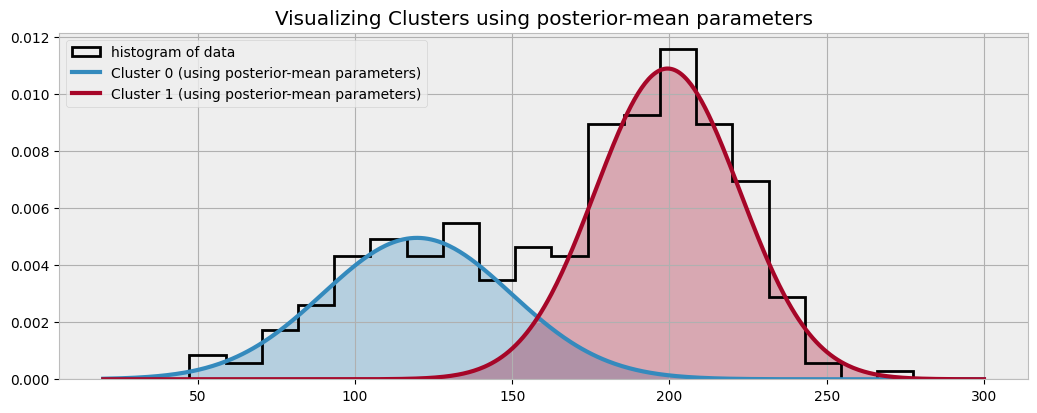

In [17]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = posterior_samples["centers"].mean(axis=0)
posterior_std_means = posterior_samples["sds"].mean(axis=0)
posterior_p_mean = posterior_samples["p"].mean()

plt.hist(data, bins=20, histtype="step", density=True, color="k",
     lw=2, label="histogram of data")
y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

### Important: Don't mix posterior samples

In the above example, a possible (though less likely) scenario is that cluster 0 has a very large standard deviation, and cluster 1 has a small standard deviation. This would still satisfy the evidence, albeit less so than our original inference. Alternatively, it would be incredibly unlikely for *both* distributions to have a small standard deviation, as the data does not support this hypothesis at all. Thus the two standard deviations are *dependent* on each other: if one is small, the other must be large. In fact, *all* the unknowns are related in a similar manner. For example, if a standard deviation is large, the mean has a wider possible space of realizations. Conversely, a small standard deviation restricts the mean to a small area. 

During MCMC, we are returned vectors representing samples from the unknown posteriors. Elements of different vectors cannot be used together, as this would break the above logic: perhaps a sample has returned that cluster 1 has a small standard deviation, hence all the other variables in that sample would incorporate that and be adjusted accordingly. It is easy to avoid this problem though, just make sure you are indexing traces correctly. 

Another small example to illustrate the point. Suppose two variables, $x$ and $y$, are related by $x+y=10$. We model $x$ as a Normal random variable with mean 4 and explore 500 samples.  

sample: 100%|███████████████████| 9000/9000 [00:23<00:00, 390.65it/s, 1 steps of size 9.65e-01. acc. prob=0.92]


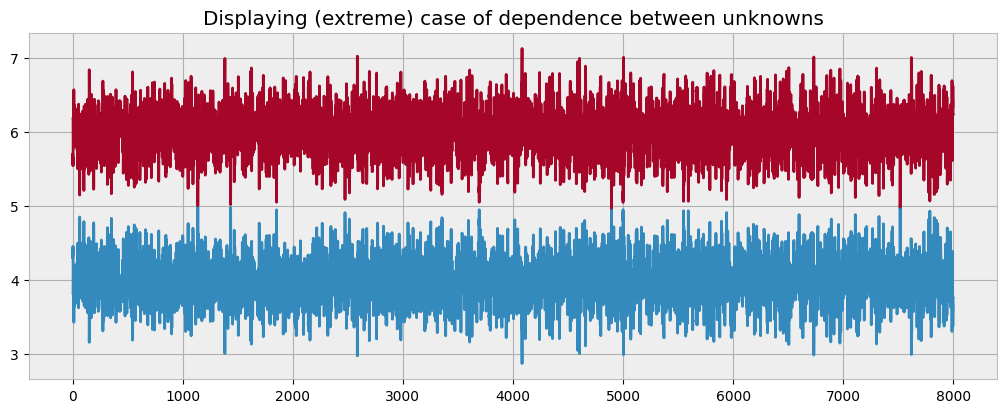

In [18]:
def model():
    x = sample("x", dist.Normal(4, 0.3))
    y = deterministic("y", 10 - x)

mcmc_dependent = MCMC(NUTS(model), num_warmup=1000, num_samples=8000)
mcmc_dependent.run(PRNGKey(1))
samples = mcmc_dependent.get_samples()

plt.plot(samples["x"])
plt.plot(samples["y"])
plt.title("Displaying (extreme) case of dependence between unknowns");

As you can see, the two variables are not unrelated, and it would be wrong to add the $i$th sample of $x$ to the $j$th sample of $y$, unless $i = j$.

#### Returning to Clustering: Prediction
The above clustering can be generalized to $k$ clusters. Choosing $k=2$ allowed us to visualize the MCMC better, and examine some very interesting plots. 

What about prediction? Suppose we observe a new data point, say $x = 175$, and we wish to label it to a cluster. It is foolish to simply assign it to the *closer* cluster center, as this ignores the standard deviation of the clusters, and we have seen from the plots above that this consideration is very important. More formally: we are interested in the *probability* (as we cannot be certain about labels) of assigning $x=175$ to cluster 1. Denote the assignment of $x$ as $L_x$, which is equal to 0 or 1, and we are interested in $P(L_x = 1 \;|\; x = 175 )$.  

A naive method to compute this is to re-run the above MCMC with the additional data point appended. The disadvantage with this method is that it will be slow to infer for each novel data point. Alternatively, we can try a *less precise*, but much quicker method. 

We will use Bayes Theorem for this. If you recall, Bayes Theorem looks like:

$$ P( A | X ) = \frac{ P( X  | A )P(A) }{P(X) }$$

In our case, $A$ represents $L_x = 1$ and $X$ is the evidence we have: we observe that $x = 175$. For a particular sample set of parameters for our posterior distribution, $( \mu_0, \sigma_0, \mu_1, \sigma_1, p)$, we are interested in asking "Is the probability that $x$ is in cluster 1 *greater* than the probability it is in cluster 0?", where the probability is dependent on the chosen parameters.

\begin{align}
& P(L_x = 1| x = 175 ) \gt P(L_x = 0| x = 175 ) \\\\[5pt]
& \frac{ P( x=175  | L_x = 1  )P( L_x = 1 ) }{P(x = 175) } \gt \frac{ P( x=175  | L_x = 0  )P( L_x = 0 )}{P(x = 175) }
\end{align}

As the denominators are equal, they can be ignored (and good riddance, because computing the quantity $P(x = 175)$ can be difficult). 

$$  P( x=175  | L_x = 1  )P( L_x = 1 ) \gt  P( x=175  | L_x = 0  )P( L_x = 0 ) $$







In [19]:
norm_pdf = stats.norm.pdf
centers = more_posterior_samples["centers"]
p = more_posterior_samples["p"]
sds = more_posterior_samples["sds"]
x = 175

v = (
    p * norm_pdf(x, loc=centers[:, 0], scale=sds[:, 0])
    > (1 - p) * norm_pdf(x, loc=centers[:, 1], scale=sds[:, 1])
)

print(f"Probability of belonging to cluster 1: {v.mean():.1%}")

Probability of belonging to cluster 1: 1.1%


Giving us a probability instead of a label is a very useful thing. Instead of the naive 

    L = 1 if prob > 0.5 else 0

we can optimize our guesses using a *loss function*, which the entire fifth chapter is devoted to.  


### Using `MAP` to improve convergence

If you ran the above example yourself, you may have noticed that our results were not consistent: perhaps your cluster division was more scattered, or perhaps less scattered. The problem is that our traces are a function of the *starting values* of the MCMC algorithm. 

It can be mathematically shown that letting the MCMC run long enough, by performing many steps, the algorithm *should forget its initial position*. In fact, this is what it means to say the MCMC converged (in practice though we can never achieve total convergence). Hence if we observe different posterior analysis, it is likely because our MCMC has not fully converged yet, and we should not use samples from it yet (we should use a larger burn-in period ).

In fact, poor starting values can prevent any convergence, or significantly slow it down. Ideally, we would like to have the chain start at the *peak* of our landscape, as this is exactly where the posterior distributions exist. Hence, if we started at the "peak", we could avoid a lengthy burn-in period and incorrect inference. Generally, we call this "peak" the *maximum a posterior* or, more simply, the *MAP*.

Of course, we do not know where the MAP is. PyMC3 provides a function that will approximate, if not find, the MAP location. In the PyMC3 main namespace is the `find_MAP` function. If you call this function within the context of `Model()`, it will calculate the MAP which you can then pass to `pm.sample()` as a `start` parameter.

    start = pm.find_MAP()
    trace = pm.sample(2000, step=pm.Metropolis, start=start)

The `find_MAP()` function has the flexibility of allowing the user to choose which optimization algorithm to use (after all, this is a optimization problem: we are looking for the values that maximize our landscape), as not all optimization algorithms are created equal. The default optimization algorithm in function call is the Broyden-Fletcher-Goldfarb-Shanno ([BFGS](https://en.wikipedia.org/wiki/Broyden-Fletcher-Goldfarb-Shanno_algorithm)) algorithm to find the maximum of the log-posterior. As an alternative, you can use other optimization algorithms from the `scipy.optimize` module. For example, you can use Powell's Method, a favourite of PyMC blogger [Abraham Flaxman](http://healthyalgorithms.com/) [1], by calling `find_MAP(fmin=scipy.optimize.fmin_powell)`. The default works well enough, but if convergence is slow or not guaranteed, feel free to experiment with Powell's method or the other algorithms available. 

The MAP can also be used as a solution to the inference problem, as mathematically it  is the *most likely* value for the unknowns. But as mentioned earlier in this chapter,  this location ignores the uncertainty and doesn't return a distribution.

#### Speaking of the burn-in period

It is still a good idea to decide on a burn-in period, even if we are using `find_MAP()` prior to sampling, just to be safe. We can no longer automatically discard sample with a `burn` parameter in the `sample()` function as we could in PyMC2, but it is easy enough to simply discard the beginning section of the trace just through array slicing. As one does not know when the chain has fully converged, a good rule of thumb is to discard the first *half* of your samples, sometimes up to 90% of the samples for longer runs. To continue the clustering example from above, the new code would look something like:

    with pm.Model() as model:
        start = pm.find_MAP()
        
        step = pm.Metropolis()
        trace = pm.sample(100000, step=step, start=start)
    
    burned_trace = trace[50000:]


## Diagnosing Convergence

### Autocorrelation

Autocorrelation is a measure of how related a series of numbers is with itself. A measurement of 1.0 is perfect positive autocorrelation, 0 no autocorrelation, and -1 is perfect negative correlation.  If you are familiar with standard *correlation*, then autocorrelation is just how correlated a series, $x_t$, at time $t$ is with the series at time $t-k$:

$$R(k) = Corr( x_t, x_{t-k} ) $$

For example, consider the two series:

$$x_t \sim \text{Normal}(0,1), \;\; x_0 = 0$$
$$y_t \sim \text{Normal}(y_{t-1}, 1 ), \;\; y_0 = 0$$

which have example paths like:

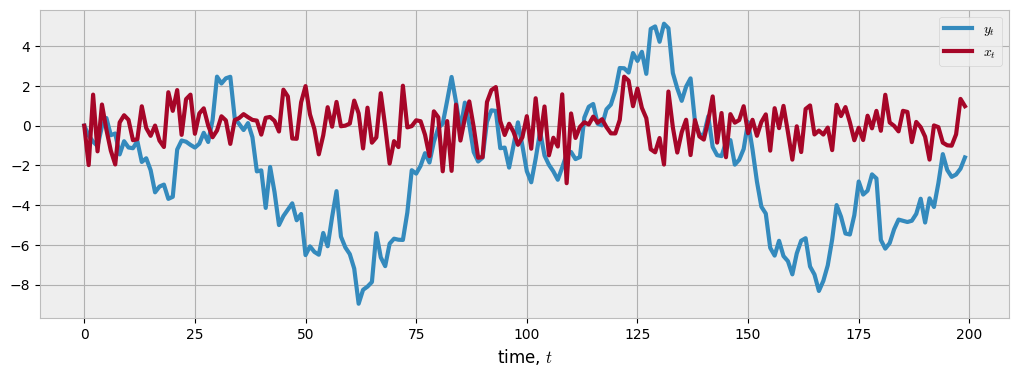

In [20]:
figsize(12.5, 4)

x_t = np.random.normal(0, 1, 200)
x_t[0] = 0
y_t = np.zeros(200)
for i in range(1, 200):
    y_t[i] = np.random.normal(y_t[i - 1], 1)

plt.plot(y_t, label="$y_t$", lw=3)
plt.plot(x_t, label="$x_t$", lw=3)
plt.xlabel("time, $t$")
plt.legend();

One way to think of autocorrelation is "If I know the position of the series at time $s$, can it help me know where I am at time $t$?" In the series $x_t$, the answer is No. By construction, $x_t$ are random variables. If I told you that $x_2 = 0.5$, could you give me a better guess about $x_3$? No.

On the other hand, $y_t$ is autocorrelated. By construction, if I knew that $y_2 = 10$, I can be very confident that $y_3$ will not be very far from 10. Similarly, I can even make a (less confident guess) about $y_4$: it will probably not be near 0 or 20, but a value of 5 is not too unlikely. I can make a similar argument about $y_5$, but again, I am less confident. Taking this to it's logical conclusion, we must concede that as $k$, the lag between time points, increases the autocorrelation decreases. We can visualize this:

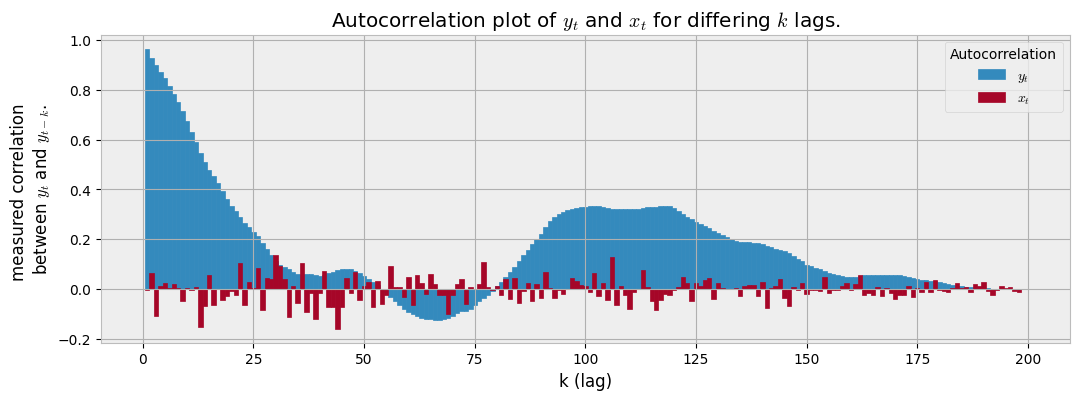

In [21]:
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

colors = ["#348ABD", "#A60628", "#7A68A6"]

x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$",
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color=colors[1], edgecolor=colors[1])

plt.legend(title="Autocorrelation")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.");

Notice that as $k$ increases, the autocorrelation of $y_t$ decreases from a very high point. Compare with the autocorrelation of $x_t$ which looks like noise (which it really is), hence we can conclude no autocorrelation exists in this series. 


#### How does this relate to MCMC convergence?

By the nature of the MCMC algorithm, we will always be returned samples that exhibit autocorrelation (this is because of the step `from your current position, move to a position near you`).

A chain that is not exploring the space well will exhibit very high autocorrelation. Visually, if the trace seems to meander like a river, and not settle down, the chain will have high autocorrelation.

This does not imply that a converged MCMC has low autocorrelation. Hence low autocorrelation is not necessary for convergence, but it is sufficient. PyMC3 has a built-in autocorrelation plotting function in the `plots` module. 

### Thinning

Another issue can arise if there is high-autocorrelation between posterior samples. Many post-processing algorithms require samples to be *independent* of each other. This can be solved, or at least reduced, by only returning to the user every $n$th sample, thus removing some autocorrelation. Below we perform an autocorrelation plot for $y_t$ with differing levels of thinning:

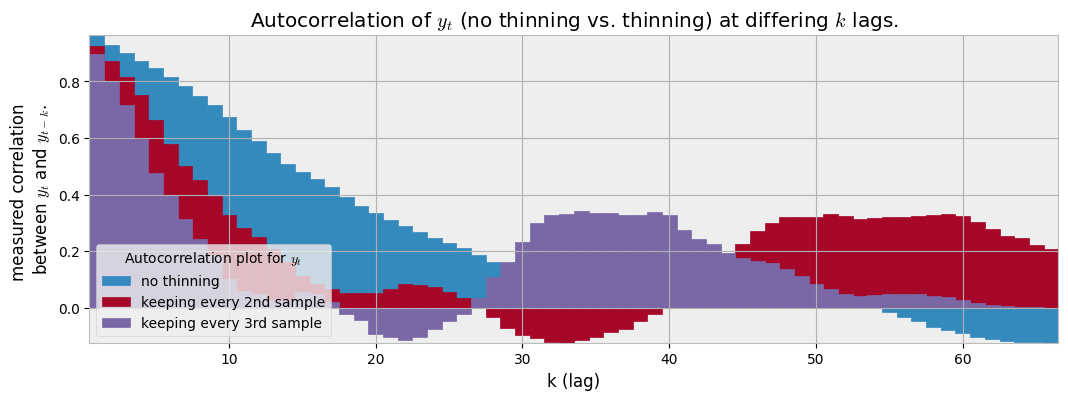

In [22]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label="no thinning", color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label="keeping every 2nd sample", color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2],
        label="keeping every 3rd sample", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="Autocorrelation plot for $y_t$", loc="lower left")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation of $y_t$ (no thinning vs. thinning) \
at differing $k$ lags.");

With more thinning, the autocorrelation drops quicker. There is a tradeoff though: higher thinning requires more MCMC iterations to achieve the same number of returned samples. For example, 10 000 samples unthinned is 100 000 with a thinning of 10 (though the latter has less autocorrelation). 

What is a good amount of thinning? The returned samples will always exhibit some autocorrelation, regardless of how much thinning is done. So long as the autocorrelation tends to zero, you are probably ok. Typically thinning of more than 10 is not necessary.

### `pymc3.plots`

It seems silly to have to manually create histograms, autocorrelation plots and trace plots each time we perform MCMC. The authors of PyMC3 have included a visualization tool for just this purpose. 

The `pymc3.plots` module contains a few different plotting functions that you might find useful. For each different plotting function contained therein, you simply pass a `trace` returned from sampling as well as a list, `varnames`, of the variables that you are interested in. This module can provide you with plots of autocorrelation and the posterior distributions of each variable and their traces, among others.

Below we use the tool to plot the centers of the clusters.

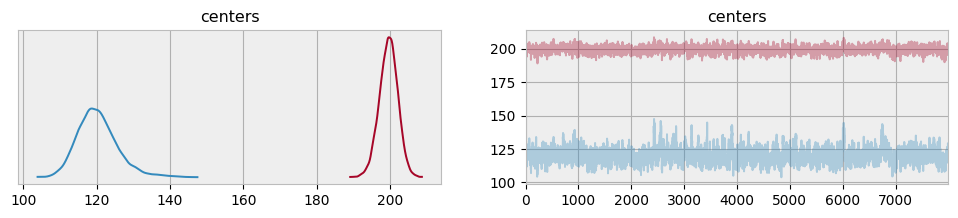

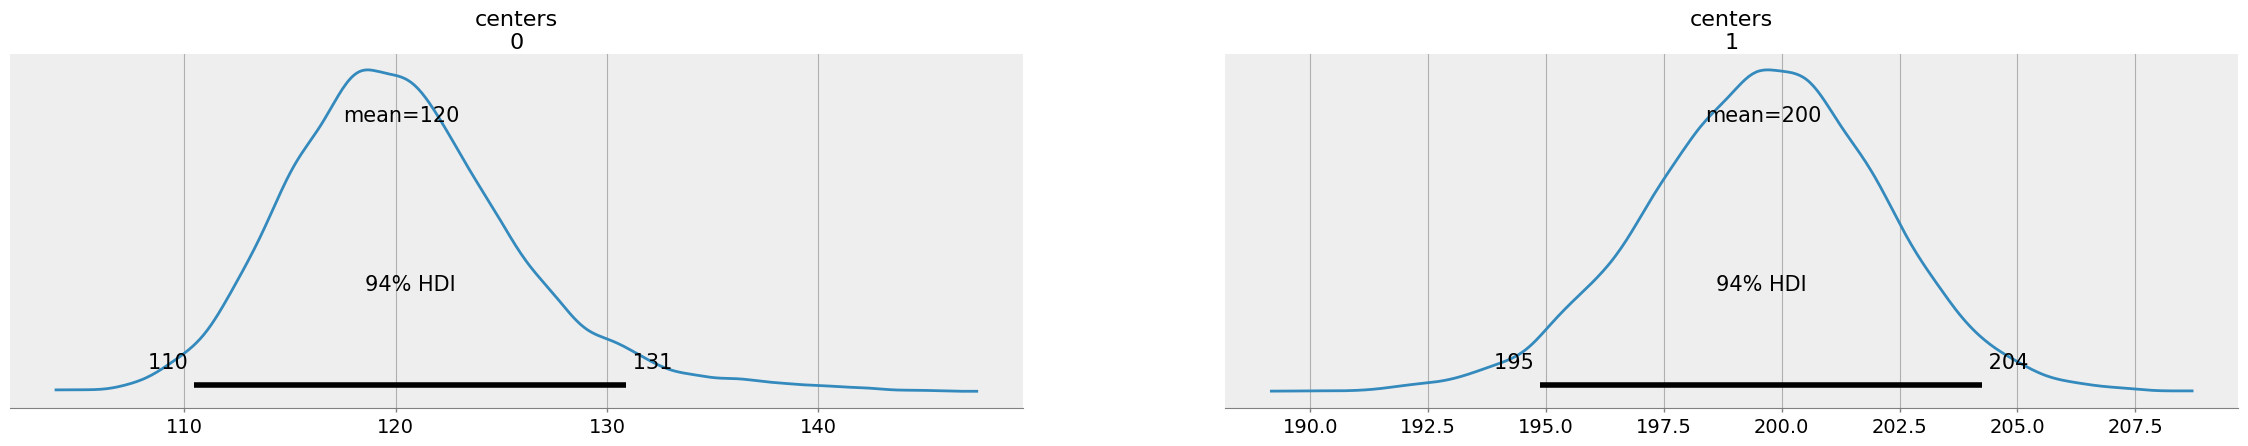

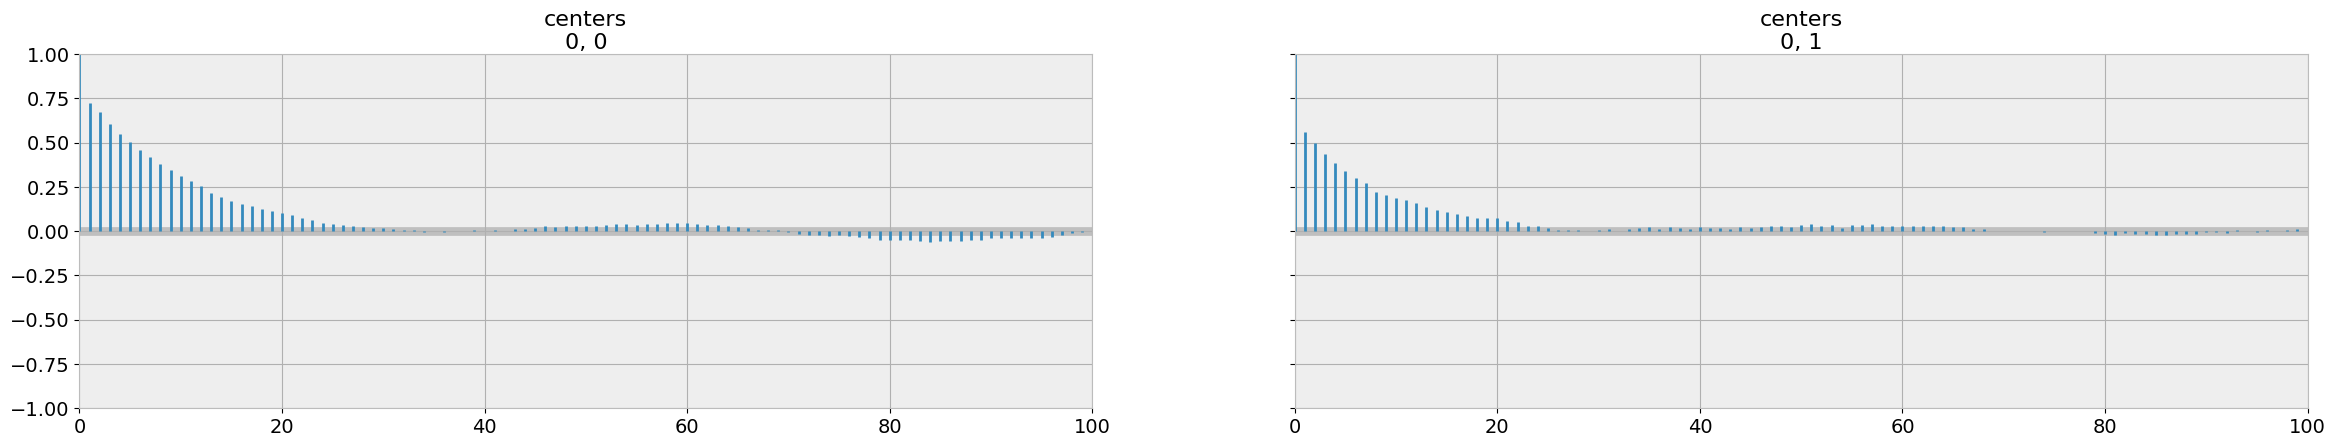

In [23]:
import arviz

inference_data = arviz.from_numpyro(mcmc)
arviz.plot_trace(inference_data, var_names=["centers"])
arviz.plot_posterior(inference_data, var_names=["centers"])
arviz.plot_autocorr(inference_data, var_names=["centers"]);

The first plotting function gives us the posterior density of each unknown in the `centers` variable as well as the `trace` of each. `trace` plot is useful for inspecting that possible "meandering" property that is a result of non-convergence. The density plot gives us an idea of the shape of the distribution of each unknown, but it is better to look at each of them individually.

The second plotting function(s) provides us with a histogram of the samples with a few added features. The text overlay in the center shows us the posterior mean, which is a good summary of posterior distribution. The interval marked by the horizontal black line overlay represents the *95% credible interval*, sometimes called the *highest posterior density interval* and not to be confused with a *95% confidence interval*. We won't get into the latter, but the former can be interpreted as "there is a 95% chance the parameter of interest lies in this interval". When communicating your results to others, it is incredibly important to state this interval. One of our purposes for studying Bayesian methods is to have a clear understanding of our uncertainty in unknowns. Combined with the posterior mean, the 95% credible interval provides a reliable interval to communicate the likely location of the unknown (provided by the mean) *and* the uncertainty (represented by the width of the interval).

The last plots, titled `center_0` and `center_1` are the generated autocorrelation plots, similar to the ones displayed above.

## Useful tips for MCMC

Bayesian inference would be the *de facto* method if it weren't for MCMC's computational difficulties. In fact, MCMC is what turns most users off practical Bayesian inference. Below I present some good heuristics to help convergence and speed up the MCMC engine:

### Intelligent starting values

It would be great to start the MCMC algorithm off near the posterior distribution, so that it will take little time to start sampling correctly. We can aid the algorithm by telling where we *think* the posterior distribution will be by specifying the `testval` parameter in the `Stochastic` variable creation. In many cases we can produce a reasonable guess for the parameter. For example, if we have data from a Normal distribution, and we wish to estimate the $\mu$ parameter, then a good starting value would be the *mean* of the data. 

     mu = pm.Uniform( "mu", 0, 100, testval = data.mean() )

For most parameters in models, there is a frequentist estimate of it. These estimates are a good starting value for our MCMC algorithms. Of course, this is not always possible for some variables, but including as many appropriate initial values is always a good idea. Even if your guesses are wrong, the MCMC will still converge to the proper distribution, so there is little to lose.

This is what using `MAP` tries to do, by giving good initial values to the MCMC. So why bother specifying user-defined values? Well, even giving `MAP` good values will help it find the maximum a-posterior. 

Also important, *bad initial values* are a source of major bugs in PyMC3 and can hurt convergence.

#### Priors

If the priors are poorly chosen, the MCMC algorithm may not converge, or atleast have difficulty converging. Consider what may happen if the prior chosen does not even contain the true parameter: the prior assigns 0 probability to the unknown, hence the posterior will assign 0 probability as well. This can cause pathological results.

For this reason, it is best to carefully choose the priors. Often, lack of covergence or evidence of samples crowding to boundaries implies something is wrong with the chosen priors (see *Folk Theorem of Statistical Computing* below). 

#### Covariance matrices and eliminating parameters

### The Folk Theorem of Statistical Computing

>   *If you are having computational problems, probably your model is wrong.*


## Conclusion

NumPyro provides a very strong backend to performing Bayesian inference, mostly because it has abstracted the inner mechanics of MCMC from the user. Despite this, some care must be applied to ensure your inference is not being biased by the iterative nature of MCMC. 

### References

1. Flaxman, Abraham. "Powell's Methods for Maximization in PyMC." Healthy Algorithms. N.p., 9 02 2012. Web. 28 Feb 2013. <http://healthyalgorithms.com/2012/02/09/powells-method-for-maximization-in-pymc/>.

In [1]:
from IPython.core.display import HTML


def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()
